In [1]:
import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.impute import SimpleImputer
import pickle
pd.set_option('display.max_columns', None)
import os

In [2]:
# access creds
with open('../psql_key.json') as file:
    creds = json.load(file)

# Create an SQLAlchemy engine with the PostgreSQL database URI
engine = create_engine(f"postgresql+psycopg2://{creds['user']}:{creds['password']}@{creds['host']}:{creds['port']}/{creds['database']}")

In [3]:
# these diag codes were taken from table mimiciv_hosp.d_icd_diagnoses
hf_codes = '''('39891','40200','40201','40210','40211','40290','40291','40400','40401','40402','40403','40410','40411','40412',
'40413','40490','40491','40492','40493','4280','4281','42820','42821','42822','42823','42830','42831','42832','42833','42840','42841',
'42842','42843','4289','E8726','E8745','I0981','I110','I119','I130','I131','I1310','I1311','I132','I50','I501','I502','I5020','I5021','I5022',
'I5023','I503','I5030','I5031','I5032','I5033','I504','I5040','I5041','I5042','I5043','I508','I5081','I50810','I50811','I50812','I50813','I50814',
'I5082','I5083','I5084','I5089','I509','I9713','I97130','I97131','T8622','T8632','Y625')'''

# get all admissions related to HF codes
query = f'''
select distinct a.subject_id , a.hadm_id , a.admittime , a.dischtime , p.gender , p.anchor_age , p.dod
from (select hadm_id from mimiciv_hosp.diagnoses_icd where icd_code in {hf_codes}) d
inner join (select * from mimiciv_hosp.admissions) a
on a.hadm_id = d.hadm_id
inner join (select * from mimiciv_hosp.patients) p
on p.subject_id = a.subject_id
'''

all_hf_pats_0 = pd.read_sql_query(query , engine)

all_hf_pats_0['dod'] = pd.to_datetime(all_hf_pats_0['dod']).dt.date
all_hf_pats_0['admittime'] = all_hf_pats_0['admittime'].dt.date
all_hf_pats_0['dischtime'] = all_hf_pats_0['dischtime'].dt.date

print(f'patients {all_hf_pats_0.subject_id.nunique()}')

patients 24348


In [4]:
# (OMR) Get online medical record data
reqd_results = ("BMI (kg/m2)" , "Height (Inches)" , "Weight (Lbs)") # Not including BP as I can get it from vitalsigns

q = f'''select distinct subject_id , chartdate , result_name , 
result_value::FLOAT from mimiciv_hosp.omr where result_name in {reqd_results}'''

omr = pd.read_sql_query(q , engine)
# omr = pd.merge(all_hf_pats_0[['subject_id']].drop_duplicates() , omr , on = 'subject_id' , how = 'inner')
omr_ = omr.sort_values(['subject_id' , 'chartdate'] , ascending = True)
omr_pivot = omr_.pivot_table(
    index = ['subject_id' , 'chartdate'] , 
    columns = 'result_name' , 
    values = 'result_value' , 
    aggfunc = 'sum'
).reset_index()

# Checksum
assert np.abs(np.sum(omr_['result_value'].to_numpy()) - np.sum(omr_pivot.iloc[: , -3:].sum(axis = 1))) <= 1e-3 , 'sums not matching'

# Check level of table
assert len(omr_pivot[['subject_id' , 'chartdate']].drop_duplicates()) == len(omr_pivot) , 'not a patient-date level table!'

# Convert to date
omr_pivot['chartdate'] = pd.to_datetime(omr_pivot['chartdate']).dt.date
omr_pivot.rename(columns = {'chartdate':'charttime'} , inplace = True)

print(omr_pivot.subject_id.nunique())

150427


In [5]:
# RACE
q = '''
select subject_id , race , count(race) as c_race
from mimiciv_hosp.admissions
group by subject_id , race
order by c_race desc
'''

race_0 = pd.read_sql_query(q , engine)
race = race_0.groupby('subject_id').first().reset_index().drop('c_race' , axis = 1)

# QC
assert len(race) == race_0["subject_id"].nunique() , 'is not patient level table'

#QC 
assert race.groupby('subject_id').agg({'race':'nunique'}).sort_values('race' , ascending = False).iloc[0 , ][0] == 1 , 'multiple races'

race_broad = pd.DataFrame( [
    ('AMERICAN INDIAN/ALASKA NATIVE','NATIVE'),
    ( 'ASIAN','ASIAN'),
    ( 'ASIAN - ASIAN INDIAN','ASIAN'),
    ( 'ASIAN - CHINESE','ASIAN'),
    ( 'ASIAN - KOREAN','ASIAN'),
    ( 'ASIAN - SOUTH EAST ASIAN','ASIAN'),
    ( 'BLACK/AFRICAN','BLACK'),
    ( 'BLACK/AFRICAN AMERICAN','BLACK'),
    ( 'BLACK/CAPE VERDEAN','BLACK'),
    ( 'BLACK/CARIBBEAN ISLAND','BLACK'),
    ( 'HISPANIC OR LATINO','HISPANIC'),
    ( 'HISPANIC/LATINO - CENTRAL AMERICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - COLUMBIAN','HISPANIC'),
    ( 'HISPANIC/LATINO - CUBAN','HISPANIC'),
    ( 'HISPANIC/LATINO - DOMINICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - GUATEMALAN','HISPANIC'),
    ( 'HISPANIC/LATINO - HONDURAN','HISPANIC'),
    ( 'HISPANIC/LATINO - MEXICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - PUERTO RICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - SALVADORAN','HISPANIC'),
    ( 'MULTIPLE RACE/ETHNICITY','OTHER'),
    ( 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','NATIVE'),
    ( 'OTHER','OTHER'),
    ( 'PATIENT DECLINED TO ANSWER','OTHER'),
    ( 'PORTUGUESE','WHITE'),
    ( 'SOUTH AMERICAN','HISPANIC'),
    ( 'UNABLE TO OBTAIN','OTHER'),
    ( 'UNKNOWN','OTHER'),
    ( 'WHITE','WHITE'),
    ( 'WHITE - BRAZILIAN','WHITE'),
    ( 'WHITE - EASTERN EUROPEAN','WHITE'),
    ( 'WHITE - OTHER EUROPEAN','WHITE'),
    ( 'WHITE - RUSSIAN','WHITE')
] , columns = ['race' , 'race_broad']
)
race = pd.merge(race , race_broad , on = 'race' , how = 'inner')
race.drop('race' , axis = 1 , inplace = True)
race.rename(columns = {'race_broad':'race'} , inplace = True)

print(race.subject_id.nunique())

180733


In [12]:
# LAB
q = '''
select distinct subject_id , charttime::DATE , itemid , sum(valuenum) as valuenum from mimiciv_hosp.labevents a 
where a.itemid = 50907 
or a.itemid = 50983
or a.itemid = 51222 
-- or a.itemid = 51133
group by subject_id , charttime , itemid 
order by subject_id , charttime
'''

bloodwork = pd.read_sql_query(q , engine) # Takes long time

bloodwork_pivot = bloodwork.pivot_table(
    index = ['subject_id' , 'charttime'] , 
    columns = 'itemid' , 
    values = 'valuenum' , 
    aggfunc = 'sum'
).reset_index()
 
# Convert to date
bloodwork_pivot['charttime'] = pd.to_datetime(bloodwork_pivot['charttime']).dt.date

# name change
bloodwork_pivot.rename(
    columns = {
        50907:'cholesterol' , 
        50983:'sodium' , 
        # 51133:'lymphocyte' , 
        51222:'hemoglobin'
    } , inplace = True)

# Checksum
assert np.abs(bloodwork['valuenum'].sum() - np.sum(bloodwork_pivot.iloc[: , -3:].sum(axis = 1))) <= 1e-3 , 'sums not matching'

# QC
assert len(bloodwork_pivot) == len(bloodwork[['subject_id' , 'charttime']].drop_duplicates()) , 'is not patient level table'

print(bloodwork_pivot.subject_id.nunique())

245879


In [13]:
# MEDICATION
hadm_id_list = "('"+"','".join(list(all_hf_pats_0['hadm_id'].unique().astype('str')))+"')"
hadm_id_list

# Note: Leaving out 'atenolol' as it does not have any usage within the cohort 
q = f'''
select a.* from
(
    select subject_id , charttime::DATE , lower(medication) as l_medication , event_txt , hadm_id
    from mimiciv_hosp.emar
    where  hadm_id::VARCHAR in {hadm_id_list}
) a
where a.l_medication in ('amlodipine','diltiazem','felodipine','isradipine','nicardipine',
'nifedipine','nisoldipine','verapamil','azilsartan','candesartan','eprosartan','irbesartan',
'losartan','olmesartan','telmisartan','valsartan','benazepril','captopril','enalapril','fosinopril',
'lisinopril','moexipril','perindopril','quinapril','ramipril','trandolapril','acebutolol','atenolol','Atenolol',
'bisoprolol','metoprolol','nadolol','nebivolol','propranolol')
and a.event_txt = 'Administered'
'''

medication = pd.read_sql_query(q , engine)
medication['medication'] = medication['l_medication']

# pivot
medication_pivot =  medication.pivot_table(
    index = ['subject_id' , 'charttime'] , 
    columns = 'l_medication' , 
    values = 'hadm_id' , 
    aggfunc = 'count'
).fillna(0)

assert medication.shape[0] == np.sum(medication_pivot.sum(axis = 1)) , 'counts not matching'

medication_pivot.reset_index(inplace = True)

# Convert to date
medication_pivot['charttime'] = pd.to_datetime(medication_pivot['charttime']).dt.date

print(medication_pivot.subject_id.nunique())

8047


In [14]:
# Vitalsigns

query = f'''
select subject_id , charttime , avg(temperature) as temperature ,
avg(heartrate) as heartrate , avg(resprate) as resprate , avg(o2sat) as o2sat , 
avg(sbp) as sbp , avg(dbp) as dbp 
from 
(
    select subject_id , charttime::DATE , temperature , heartrate , resprate , o2sat , sbp , dbp
    from mimiciv_ed.vitalsign
) a
group by subject_id , charttime
'''
vitalsign = pd.read_sql_query(query , engine)

# Convert to date
vitalsign['charttime'] = pd.to_datetime(vitalsign['charttime']).dt.date

assert len(vitalsign) == len(vitalsign[['subject_id' , 'charttime']].drop_duplicates()) , 'is not patient level table'

print(vitalsign.subject_id.nunique())

198131


In [16]:
# Comorbidities
comorbidity_dict = {
    'hypertension':['G932','H4005','H40051','H40052','H40053','H40059','I10','I15','I150','I158','I159','I270','I272','I2720','I2721','I2722','I2723','I2724','I2729','I873','I8730','I87301','I87302','I87303','I87309','I8731','I87311','I87312','I87313','I87319','I8732','I87321','I87322','I87323','I87329','I8733','I87331','I87332','I87333','I87339','I8739','I87391','I87392','I87393','I87399','I973','K766','O10','O100','O1001','O10011','O10012','O10013','O10019','O1002','O1003','O104','O1041','O10411','O10412','O10413','O10419','O1042','O1043','O109','O1091','O10911','O10912','O10913','O10919','O1092','O1093','O11','O111','O112','O113','O114','O115','O119','O12','O13','O131','O132','O133','O134','O135','O139','O16','O161','O162','O163','O164','O165','O169','P292','P2930','R030'],
    'obesity':['E66', 'E6601', 'E6609', 'E661', 'E662', 'E668'],
    'diabetes':['E101','E09','E090','E0900','E0901','E091','E0910','E0911','E092','E0921','E0922','E0929','E093','E0931','E09311','E09319','E0932','E09321','E093211','E093212','E093213','E093219','E09329','E093291','E093292','E093293','E093299','E0933','E09331','E093311','E093312','E093313','E093319','E09339','E093391','E093392','E093393','E093399','E0934','E09341','E093411','E093412','E093413','E093419','E09349','E093491','E093492','E093493','E093499','E0935','E09351','E093511','E093512','E093513','E093519','E09352','E093521','E093522','E093523','E093529','E09353','E093531','E093532','E093533','E093539','E09354','E093541','E093542','E093543','E093549','E09355','E093551','E093552','E093553','E093559','E09359','E093591','E093592','E093593','E093599','E0936','E0937','E0937X1','E0937X2','E0937X3','E0937X9','E0939','E094','E0940','E0941','E0942','E0943','E0944','E0949','E095','E0951','E0952','E0959','E096','E0961','E09610','E09618','E0962','E09620','E09621','E09622','E09628','E0963','E09630','E09638','E0964','E09641','E09649','E0965','E0969','E098','E099','E10','E1010','E1011','E102','E1021','E1022','E1029','E103','E1031','E10311','E10319','E1032','E10321','E103211','E103212','E103213','E103219','E10329','E103291','E103292','E103293','E103299','E1033','E10331','E103311','E103312','E103313','E103319','E10339','E103391','E103392','E103393','E103399','E1034','E10341','E103411','E103412','E103413','E103419','E10349','E103491','E103492','E103493','E103499','E1035','E10351','E103511','E103512','E103513','E103519','E10352','E103521','E103522','E103523','E103529','E10353','E103531','E103532','E103533','E103539','E10354','E103541','E103542','E103543','E103549','E10355','E103551','E103552','E103553','E103559','E10359','E103591','E103592','E103593','E103599','E1036','E1037','E1037X1','E1037X2','E1037X3','E1037X9','E1039','E104','E1040','E1041','E1042','E1043','E1044','E1049','E105','E1051','E1052','E1059','E106','E1061','E10610','E10618','E1062','E10620','E10621','E10622','E10628','E1063','E10630','E10638','E1064','E10641','E10649','E1065','E1069','E108','E109','E11','E110','E1100','E1101','E111','E1110','E1111','E112','E1121','E1122','E1129','E113','E1131','E11311','E11319','E1132','E11321','E113211','E113212','E113213','E113219','E11329','E113291','E113292','E113293','E113299','E1133','E11331','E113311','E113312','E113313','E113319','E11339','E113391','E113392','E113393','E113399','E1134','E11341','E113411','E113412','E113413','E113419','E11349','E113491','E113492','E113493','E113499','E1135','E11351','E113511','E113512','E113513','E113519','E11352','E113521','E113522','E113523','E113529','E11353','E113531','E113532','E113533','E113539','E11354','E113541','E113542','E113543','E113549','E11355','E113551','E113552','E113553','E113559','E11359','E113591','E113592','E113593','E113599','E1136','E1137','E1137X1','E1137X2','E1137X3','E1137X9','E1139','E114','E1140','E1141','E1142','E1143','E1144','E1149','E115','E1151','E1152','E1159','E116','E1161','E11610','E11618','E1162','E11620','E11621','E11622','E11628','E1163','E11630','E11638','E1164','E11641','E11649','E1165','E1169','E118','E119','E13','E130','E1300','E1301','E131','E1310','E1311','E132','E1321','E1322','E1329','E133','E1331','E13311','E13319','E1332','E13321','E133211','E133212','E133213','E133219','E13329','E133291','E133292','E133293','E133299','E1333','E13331','E133311','E133312','E133313','E133319','E13339','E133391','E133392','E133393','E133399','E1334','E13341','E133411','E133412','E133413','E133419','E13349','E133491','E133492','E133493','E133499','E1335','E13351','E133511','E133512','E133513','E133519','E13352','E133521','E133522','E133523','E133529','E13353','E133531','E133532','E133533','E133539','E13354','E133541','E133542','E133543','E133549','E13355','E133551','E133552','E133553','E133559','E13359','E133591','E133592','E133593','E133599','E1336','E1337','E1337X1','E1337X2','E1337X3','E1337X9','E1339','E134','E1340','E1341','E1342','E1343','E1344','E1349','E135','E1351','E1352','E1359','E136','E1361','E13610','E13618','E1362','E13620','E13621','E13622','E13628','E1363','E13630','E13638','E1364','E13641','E13649','E1365','E1369','E138','E139','N251','O240','O2401','O24011','O24012','O24013','O24019','O2402','O2403','O241','O2411','O24111','O24112','O24113','O24119','O2412','O2413','O243','O2431','O24311','O24312','O24313','O24319','O2432','O2433','O244','O2441','O24410','O24414','O24415','O24419','O2442','O24420','O24424','O24425','O24429','O2443','O24430','O24434','O24435','O24439','O248','O2481','O24811','O24812','O24813','O24819','O2482','O2483','O249','O2491','O24911','O24912','O24913','O24919','O2492','O2493','P700','P702','R7303','Z131','Z833','Z8632']
    }

comorbidity_list = [diag_cd for diag_codes in list(comorbidity_dict.values()) for diag_cd in diag_codes]

#-------------------------------------------------------------------------------------------------------
df_comorbidities = {}

for key, values in comorbidity_dict.items():
    for value in values:
        df_comorbidities[value] = key

# convert to df
comorbid_code_df = pd.DataFrame.from_dict(df_comorbidities , orient = 'index' , columns = ['comorbidity']).reset_index().rename(columns = {'index':'icd_code'})

# MEDICATION
comorbidity_codes_list = "('"+"','".join(list(comorbidity_list))+"')"
print(comorbidity_codes_list)

query = f'''
select distinct subject_id , icd_code from mimiciv_hosp.diagnoses_icd where icd_code in {comorbidity_codes_list}
'''

comorbidity = pd.read_sql_query(query , engine)

# remove trailing whitespace
comorbidity['icd_code'] = comorbidity['icd_code'].str.rstrip()

# merge
comorbidity_2 = pd.merge(comorbidity , comorbid_code_df , on = 'icd_code')

# add helper
comorbidity_2['helper'] = 1

# test
assert comorbidity_2.pivot_table(index = 'subject_id' , columns = 'comorbidity' , values = 'helper' , aggfunc = 'sum').fillna(0).sum().sum() == len(comorbidity_2) , 'pivot counts not matching'

# pivot
comorbidity_pivot = comorbidity_2.pivot_table(index = 'subject_id' , columns = 'comorbidity' , values = 'helper').fillna(0).reset_index()

('G932','H4005','H40051','H40052','H40053','H40059','I10','I15','I150','I158','I159','I270','I272','I2720','I2721','I2722','I2723','I2724','I2729','I873','I8730','I87301','I87302','I87303','I87309','I8731','I87311','I87312','I87313','I87319','I8732','I87321','I87322','I87323','I87329','I8733','I87331','I87332','I87333','I87339','I8739','I87391','I87392','I87393','I87399','I973','K766','O10','O100','O1001','O10011','O10012','O10013','O10019','O1002','O1003','O104','O1041','O10411','O10412','O10413','O10419','O1042','O1043','O109','O1091','O10911','O10912','O10913','O10919','O1092','O1093','O11','O111','O112','O113','O114','O115','O119','O12','O13','O131','O132','O133','O134','O135','O139','O16','O161','O162','O163','O164','O165','O169','P292','P2930','R030','E66','E6601','E6609','E661','E662','E668','E101','E09','E090','E0900','E0901','E091','E0910','E0911','E092','E0921','E0922','E0929','E093','E0931','E09311','E09319','E0932','E09321','E093211','E093212','E093213','E093219','E09329','

### **Joining**

In [17]:
# Patients with presence in all tables
charttime_pats = list(set(bloodwork_pivot['subject_id']).\
intersection(set(vitalsign['subject_id'])).\
intersection(set(medication_pivot['subject_id'])).\
intersection(set(omr_pivot['subject_id'])).\
intersection(set(race['subject_id']))
)

print(f'patients {len(charttime_pats)}')

df_1 = pd.merge(
    vitalsign , bloodwork_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_2 = pd.merge(
    df_1 , medication_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_3 = pd.merge(
    df_2 , omr_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_4 = pd.merge(
    df_3 , race , 
    on = 'subject_id' , 
    how = 'inner'
)

# sort by patient-time
df_4.sort_values(['subject_id' , 'charttime'] , inplace = True)

# only keep patients who have presence in all tables
df_4 = df_4[df_4['subject_id'].isin(charttime_pats)]


df_5 = pd.merge(
    df_4 , comorbidity_pivot , 
    on = 'subject_id' , 
    how = 'left' # do not want to inner join as not all HF pats will have at least 1 comorbidity
)

print(f'patients {df_5.subject_id.nunique()}')

patients 6627
patients 6627


In [18]:
# Retain patients who do not have any presence in the charttime
retain_pats = df_5.groupby('subject_id').agg({'charttime':'nunique'})
retain_pats = retain_pats[retain_pats['charttime'] != 0]
retain_pats = retain_pats.reset_index().drop('charttime', axis=1).drop_duplicates()

#### **Get Survival Metrics**

In [19]:
# Retain all patients
# Add num of ICU admits / num of admissions as covariates
# Time of survival -> from last ICU admission to deathtime / OR first ICU admission?
# Uncensored patients (those that experienced the event, i.e. died)
# Find latest ICU admission
tos_hf = all_hf_pats_0.groupby('subject_id').agg({'admittime':'min' , 'dod':'max' , 'dischtime':'max'})

# add gender and age
tos_hf = pd.merge(
    tos_hf,  all_hf_pats_0[['subject_id','gender','anchor_age']].drop_duplicates(),
    on = 'subject_id',
    how = 'inner'
)

event_pats = tos_hf[tos_hf['dod'].notnull()].copy()
event_pats['time_to_event'] = event_pats['dod'] - event_pats['admittime']
event_pats['time_to_event'] = event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
event_pats['death'] = 1

# who are the censored patients?
non_event_pats = tos_hf[tos_hf['dod'].isnull()].copy()# For censored patients, their last follow-up was essentially their discharge time
non_event_pats['time_to_event'] = non_event_pats['dischtime'] - non_event_pats['admittime']
non_event_pats['time_to_event'] = non_event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
# non_event_pats['time_to_event'] = non_event_pats['time_to_event'] + 365 # is this necessary?
non_event_pats['death'] = 0
# non_event_pats.head(3)

pats = pd.concat([
    non_event_pats[['subject_id','time_to_event' , 'death', 'gender', 'anchor_age']] , 
    event_pats[['subject_id','time_to_event' , 'death' , 'gender', 'anchor_age']]] , axis = 0)

pats.sort_values('subject_id' , inplace = True)

pats['time_to_event'] = pats['time_to_event'].apply(lambda x: x+1 if x==0 else x)
# QC
print(pats.count())

# QC
assert len(pats) == all_hf_pats_0["subject_id"].nunique() , 'is not patient level table'

subject_id       24348
time_to_event    24348
death            24348
gender           24348
anchor_age       24348
dtype: int64


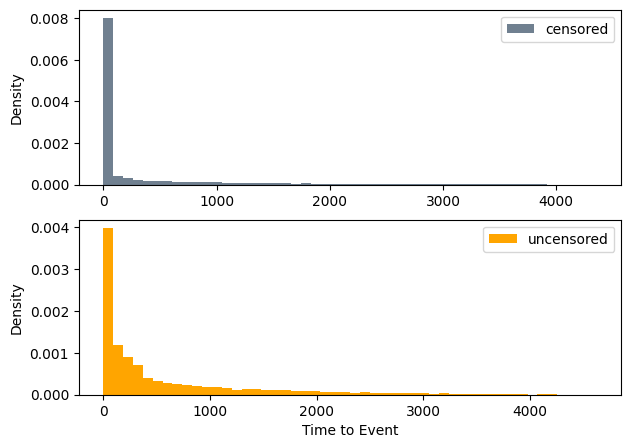

In [20]:
grouped = pats.groupby('death')
labels = ['censored' , 'uncensored']
colors = ['slategray' , 'orange']
# Plot grouped histogram
fig, axes = plt.subplots(2 , figsize = (7,5))
            
for category, group in grouped:
    axes[category].hist(group['time_to_event'], bins=50 , density = True , label = labels[category] , color = colors[category])
    axes[category].legend()
    axes[category].set_ylabel('Density')

plt.xlabel('Time to Event')
# plt.title('Cohort-wise Time-to-Event Distribution')

# Save the plot as an PDF file
# plt.savefig('cohort_hist.pdf', format='pdf')

plt.show()

In [21]:
consolidated_pat_tbl = pd.merge(df_5 , pats , on = 'subject_id' , how = 'inner')
print(f'number of patients before retaining = {consolidated_pat_tbl.subject_id.nunique()}')
consolidated_pat_tbl = pd.merge(consolidated_pat_tbl , retain_pats , on = 'subject_id' , how = 'inner')

# # Forwardfilling columns
# forwardfill_cols = [
#     'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin', 'temperature', 
#     'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp'
#     ]

# for col in forwardfill_cols:
#     consolidated_pat_tbl[col] = consolidated_pat_tbl.groupby('subject_id')[col].fillna(method = 'ffill')

# # na -> zero columns (Must do this AFTER backfilling!)
# consolidated_pat_tbl.fillna(0 , inplace = True)

print(f'number of patients after retaining = {consolidated_pat_tbl.subject_id.nunique()}')

assert len(consolidated_pat_tbl) == len(consolidated_pat_tbl[['subject_id','charttime']].drop_duplicates()) , 'not patient-time level!'

number of patients before retaining = 6627
number of patients after retaining = 6627


In [22]:
# Time difference calculation at patient level
consolidated_pat_tbl['lag_time'] = consolidated_pat_tbl.groupby('subject_id')['charttime'].shift(1)
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['charttime'] - consolidated_pat_tbl['lag_time']
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['timediff'].fillna(pd.Timedelta(0))
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['timediff']/np.timedelta64(1 , 'D')

**Retain patients with at least n time steps**

In [23]:
def retain_n_time_steps(df, subject_col, ts_col, n_time_steps = 10):
    arr = df.groupby(subject_col).agg({ts_col:'count'})[ts_col]
    
    # Calculate the quantile value using np.quantile - patients below this quantile are rejected
    print(f'% rejected pats {100*np.sum(arr < n_time_steps)/len(arr)}')
    
    _retain_pats = df.groupby(subject_col).agg({ts_col:'count'}).reset_index()
    _retain_pats = _retain_pats[_retain_pats[ts_col] >= n_time_steps]

    df_retained = pd.merge(df , _retain_pats[[subject_col]] , on = subject_col , how = 'inner')

    # check operations correctness
    assert np.sum(arr < n_time_steps)/len(arr) == (df[subject_col].nunique() - df_retained[subject_col].nunique())/df[subject_col].nunique() , 'does not match'
    
    return df_retained

In [24]:
consolidated_pat_tbl_retained = retain_n_time_steps(
    consolidated_pat_tbl.drop(['charttime','lag_time'] , axis = 1),
    'subject_id' , 'timediff' , n_time_steps = 10
    )

% rejected pats 10.909913988229968


In [25]:
folder_path = "data/"

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)

# Pickle the DataFrame (tv -> time variant)
with open('data/consolidated_pat_tbl_tv.pickle', 'wb') as file:
    pickle.dump(consolidated_pat_tbl_retained, file)

------------